## Module 3 Project - Bank Marketing Classification

* Jonathan Bardey
* Flatiron School - Data Science


### Introduction
* For this project, we will use supervised Machine Learning models to classify and predict whether potential customers of a bank direct marketing campaign subscribe to the bank term deposit.
* Several models will be trained and evaluated using metrics such as Accuracy, Precision and Recall.
* Attributes of the dataset will be analyzed to determine the most important predictors of our target class.

In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

#universal random state for modeling
random_state = 42

Using TensorFlow backend.


In [2]:
#read in and preview the dataset
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

### Attribute Information:

#### Input variables:
##### Client data:
1. age (numeric) 
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown') 

##### Related with the last contact of the current campaign: 
8. contact: contact communication type (categorical: 'cellular','telephone')
9.   month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. 

##### Other attributes: 
12.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14.  previous: number of contacts performed before this campaign and for this client (numeric)
15.  poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') 


##### Social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)


#### Output variable (desired target)
21. y - has the client subscribed a term deposit? (binary: 'yes','no') 

#### Source:
Dataset from : http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

In [3]:
#Preview the columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [4]:
#check for null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no null values.  Thanks UCI for the clean dataset!

In [5]:
#Look at five point statistics for numerical features
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
#Rename target column to 'deposit' as we want to ascertain whether or not the client subscribed to a term deposit
df.rename(columns = {'y' : 'deposit'}, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


no     36548
yes     4640
Name: deposit, dtype: int64


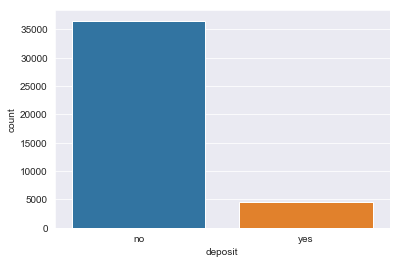

11.27% of the 41188 calls resulted in deposits.


In [7]:
#lets check and plot occurences of our target variable 'deposit'
print(df.deposit.value_counts())
sns.countplot(df.deposit)
plt.show()
print(f'{round(sum(df.deposit == "yes") / len(df)*100, 2)}% of the {len(df)} calls resulted in deposits.')

As seen above the dataset is imbalanced towards 'no' deposit.  At a later stage we may want use a resampling technique to balance our data for modeling.

#### Examining the Duration Column
According to the provided dataset information, the duration feature "*highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*" <br>
Before discarding the column, I just want to look at distributions for duration of calls by target class.

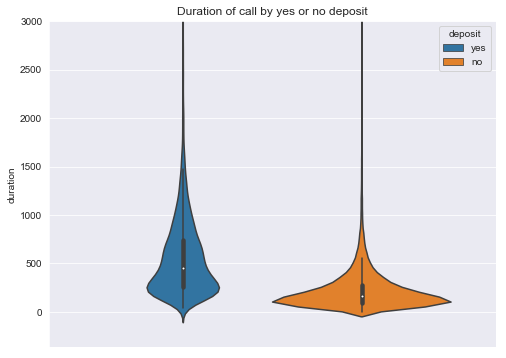

In [8]:
#violin plot of duration by yes or no deposit
df['all'] = ""
plt.figure(figsize=(8,6))
sns.violinplot(x="all", y="duration", hue="deposit", hue_order=['yes', 'no'], orient="v", data=df)
plt.xlabel("")
plt.title("Duration of call by yes or no deposit")
plt.ylim(top=3000)
plt.show()
df = df.drop('all', axis=1)

In [9]:
duration_yes = df.duration[df.deposit == 'yes']
duration_no = df.duration[df.deposit == 'no']

print(f'The mean call duration leading to a deposit is {round(duration_yes.mean()/60, 2)} minutes.')
print(f'The mean call duration leading to no is {round(duration_no.mean()/60, 2)} minutes.')

The mean call duration leading to a deposit is 9.22 minutes.
The mean call duration leading to no is 3.68 minutes.


We see that there is definitely a noticeable difference in call duration for the two classes.  The average call that leads to a client subscribing to the term deposit is more than 5 minutes longer that for non-subscribers.  Intuitively, this makes sense as clients with more interest in the product would stay on the phone longer.  We will take the recommendation from the dataset provider and discard the column.

In [10]:
#dropping Duration column
df.drop('duration', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Feature Exploration

Next we will separate the numerical and categorical features for further exploration.

In [11]:
cat_features = df.select_dtypes(include = ['object'])
cat_features = cat_features.drop('deposit', axis=1)
num_features = df.select_dtypes(include = ['int64', 'float64'])
print(f'There are {len(cat_features.columns)} categorical features.\n')
print(cat_features.columns)
print('-' * 50)
print(f'There are {len(num_features.columns)} numerical features.\n')
print(num_features.columns)

There are 10 categorical features.

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')
--------------------------------------------------
There are 9 numerical features.

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [12]:
cat_features.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


job:

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


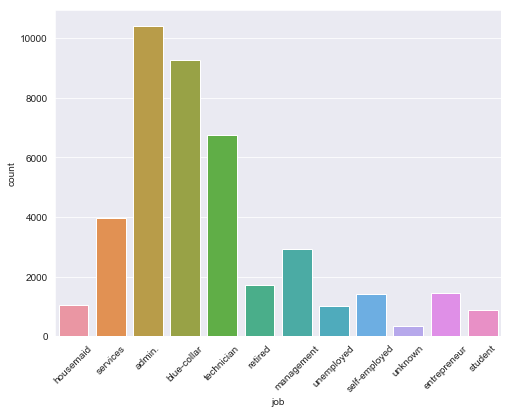

marital:

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


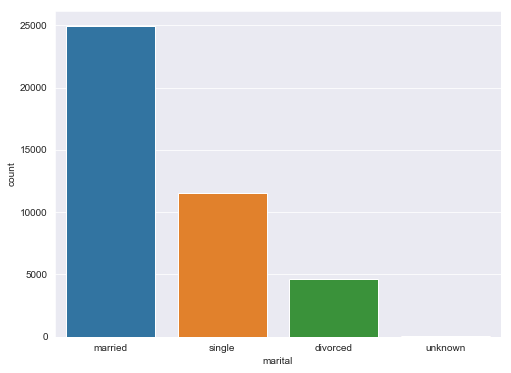

education:

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


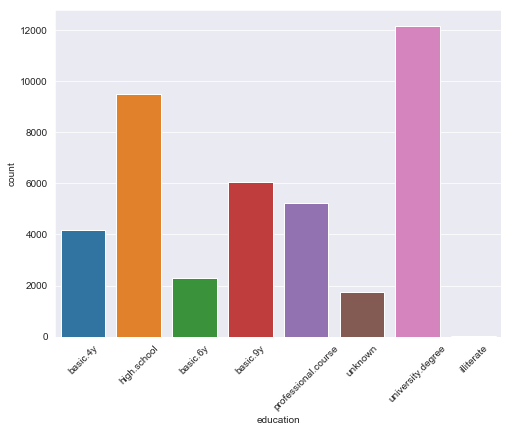

default:

no         32588
unknown     8597
yes            3
Name: default, dtype: int64


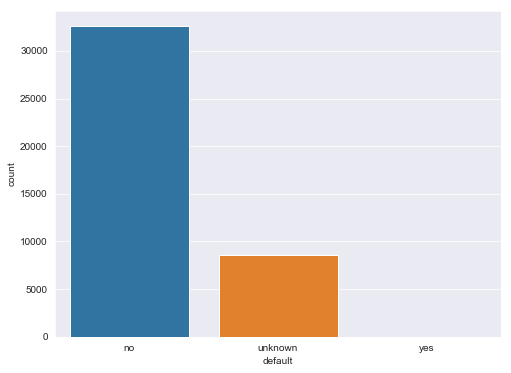

housing:

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


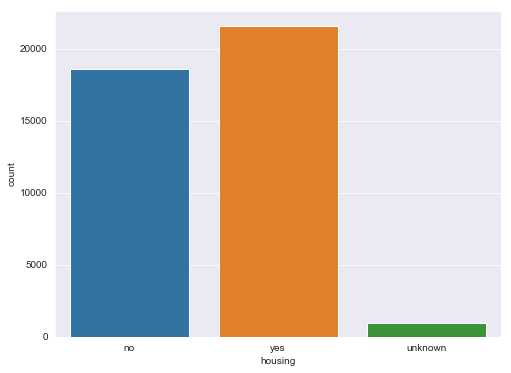

loan:

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


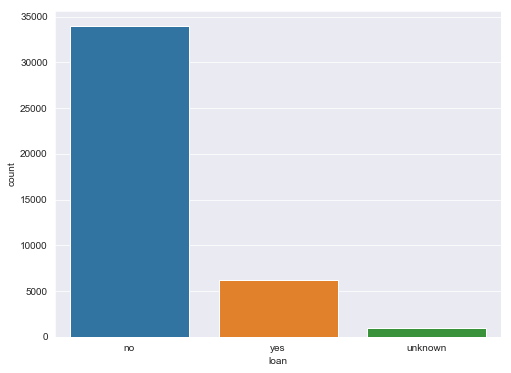

contact:

cellular     26144
telephone    15044
Name: contact, dtype: int64


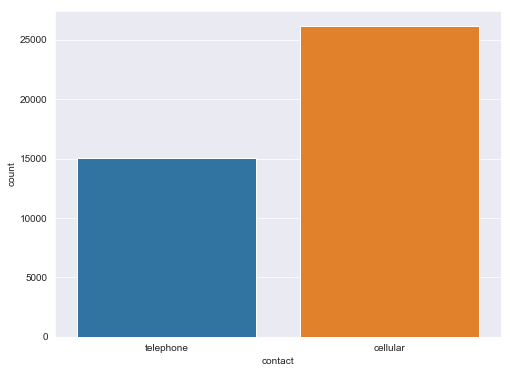

month:

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64


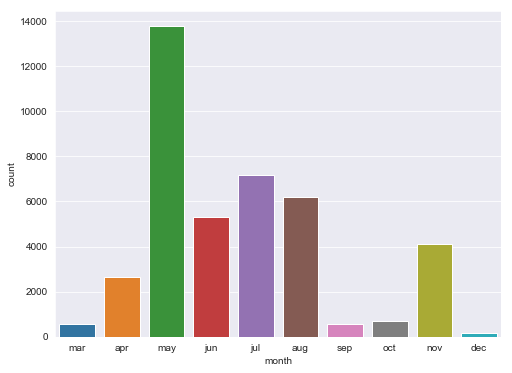

day_of_week:

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64


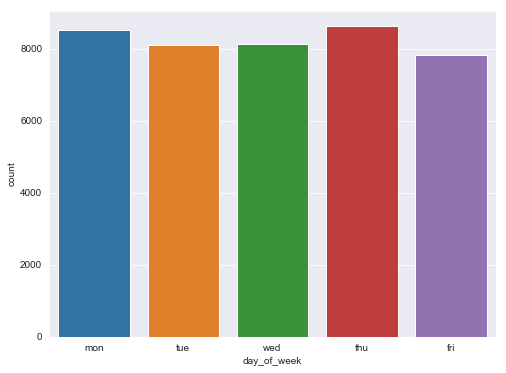

poutcome:

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64


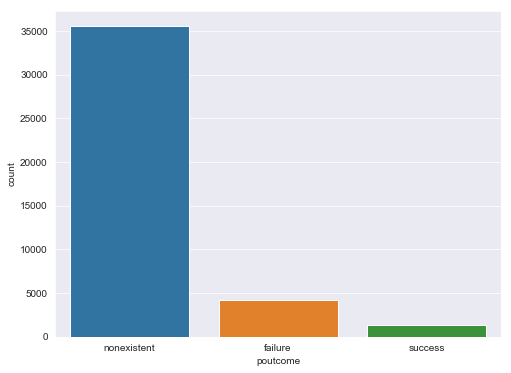

In [13]:
#Visualize unique values and countplots for each of the categorical variables
for col in cat_features:
    print(f'{col}:\n')
    print(cat_features[col].value_counts())
    plt.figure(figsize=(8,6))
    if col == 'month':
        sns.countplot(x = col, data = cat_features, 
                      order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
    else:
        sns.countplot(x = col, data = cat_features)
        if col == 'job' or col == 'education':
            plt.xticks(rotation = 45)
    plt.show()

Let's take a look at histograms of our numerical columns to get a sense of the data.  We will then decide if we need to apply a scaler to these features.

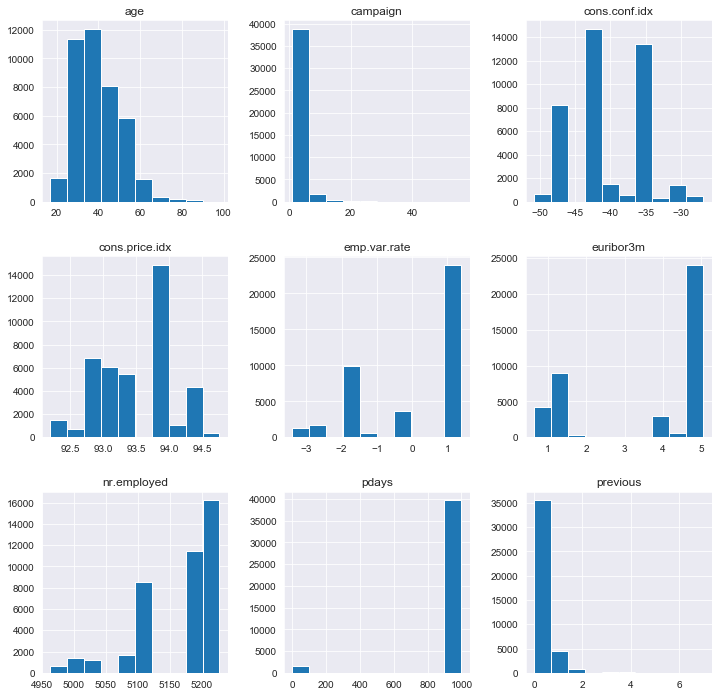

In [14]:
#Plot histograms of numerical columns
num_features.hist(figsize=(12,12))
plt.show()

Now we will look at a Correlation Matrix to check for multicollinearity among numerical features.

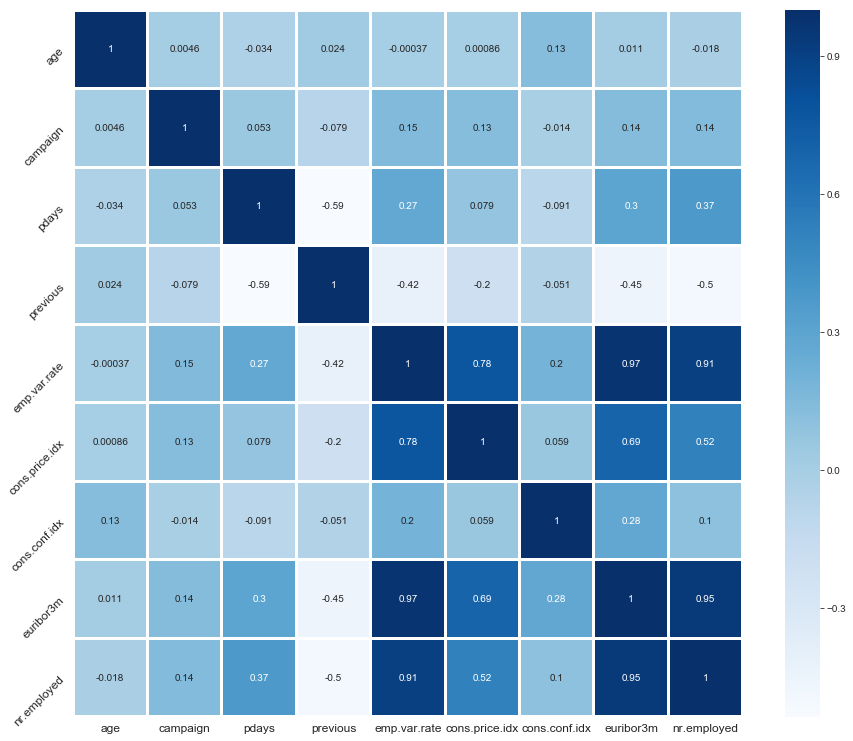

In [15]:
corr = num_features.corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr, fmt='.2g', cmap = 'Blues', annot = True, linewidth = 2, robust = True)
plt.xticks(size = 12)
plt.yticks(size = 12, rotation=45)
plt.show()

Next we will visualize a box plot to visualize the scale and outliers of our numerical features.

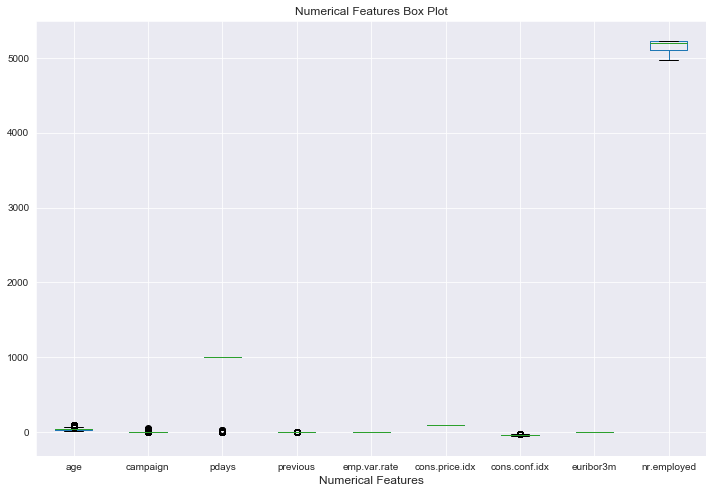

In [16]:
num_features.boxplot(figsize=(12,8))
plt.xlabel('Numerical Features', size=12)
plt.title('Numerical Features Box Plot')
plt.show()

The 'nr.employed' column is clearly on a completely different scale from the other features, so we will look at the box plots again without that feature.

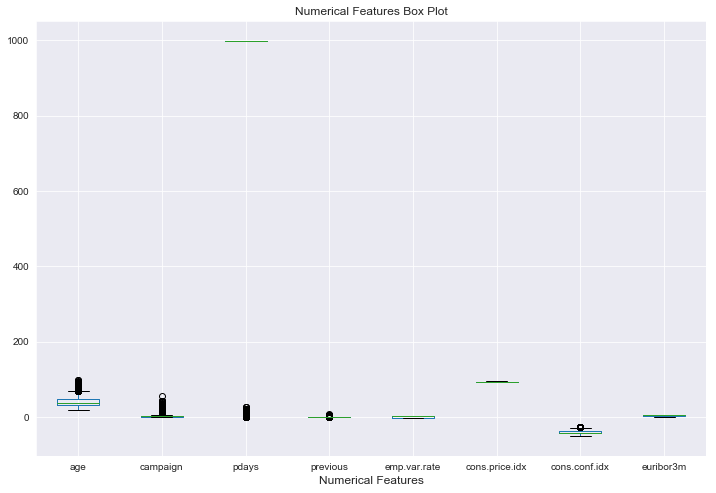

In [17]:
num_features.drop(columns = "nr.employed").boxplot(figsize=(12,8))
plt.xlabel('Numerical Features', size=12)
plt.title('Numerical Features Box Plot')
plt.show()

Let's take a closer look at the pdays column:

In [18]:
num_features.pdays.describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

In [19]:
num_features.pdays.value_counts()[:10]

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
Name: pdays, dtype: int64

Fronm the data description above the 'pday' column assigns '999' when the client was not previously contacted, therefore the green line for the pdays columns.  We will take one more look at the box plots without that column as well just to get a sense of the scale of the rest of our features

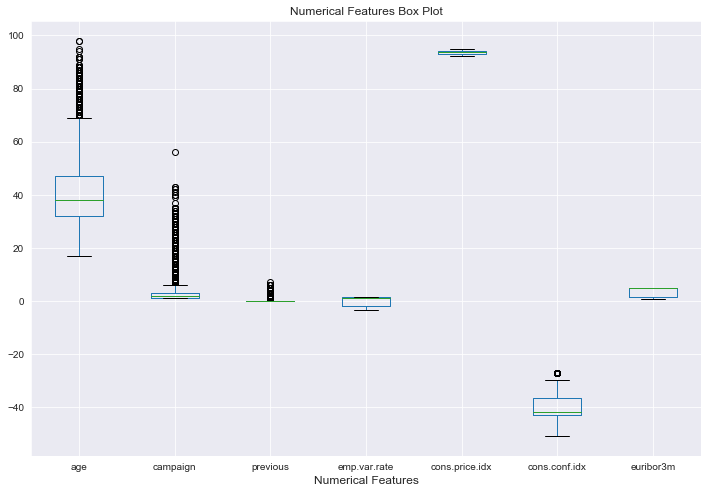

In [20]:
num_features.drop(columns = ["nr.employed", "pdays"]).boxplot(figsize=(12,8))
plt.xlabel('Numerical Features', size=12)
plt.title('Numerical Features Box Plot')
plt.show()

That gives us a much better look at the range and scale of the numerical features.  There is still a significant variance in scale of the numerical data (especially for the consumer confidence index and consumer price index) so we will want to scale our features to prepare them for machine learning modeling.


### Preprocessing the Data

Here we will one hot encode the categorical features to make the suitable for modeling.

In [21]:
dummified_features = pd.get_dummies(cat_features, drop_first=True)

dummified_features.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


Next we will scale our numerical features using sklearn's Standard Scaler to ensure that features on different scales do not have an outsized effect on our models' results.  

In [22]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(num_features)

scaled_feats = pd.DataFrame(scaled_feats, columns = num_features.columns)
scaled_feats.head()


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


In [23]:
scaled_feats.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4.118800e+04,4.118800e+04,4.118800e+04,4.118800e+04,4.118800e+04,4.118800e+04,4.118800e+04,41188.000000,4.118800e+04
mean,-1.880382e-16,-7.590531e-17,-2.580781e-16,5.520386e-18,7.797546e-17,8.667007e-15,-1.352495e-16,0.000000,-1.024860e-14
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012,1.000012e+00
min,-2.209365e+00,-5.659220e-01,-5.149443e+00,-3.494943e-01,-2.216433e+00,-2.374889e+00,-2.224953e+00,-1.722351,-2.815697e+00
25%,-7.699804e-01,-5.659220e-01,1.954139e-01,-3.494943e-01,-1.197935e+00,-8.649547e-01,-4.747909e-01,-1.312994,-9.402810e-01
50%,-1.942267e-01,-2.049085e-01,1.954139e-01,-3.494943e-01,6.480923e-01,2.994571e-01,-2.803284e-01,0.712460,3.316799e-01
75%,6.694038e-01,1.561049e-01,1.954139e-01,-3.494943e-01,8.390606e-01,7.227225e-01,8.864466e-01,0.772422,8.451701e-01
max,5.563310e+00,1.928982e+01,1.954139e-01,1.379492e+01,8.390606e-01,2.058168e+00,2.939106e+00,0.820853,8.451701e-01


As we see above, each of our features has been scaled to a mean of 0 and standard deviation of 1.

We will take another look at the histograms and box plots after scaling our features.

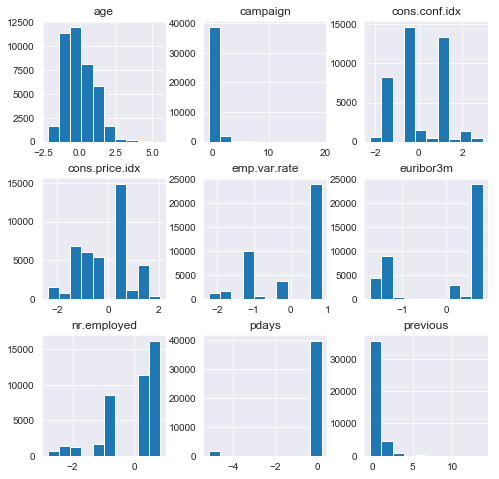

In [24]:
#Plot histograms of numerical columns
scaled_feats.hist(figsize=(8,8))
plt.show()

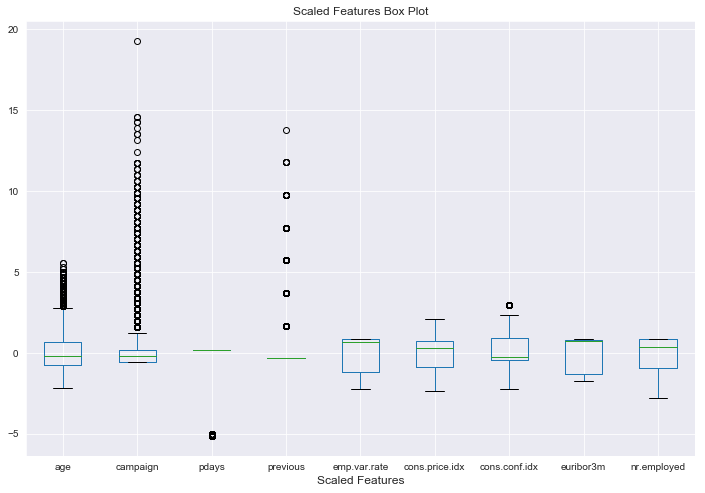

In [25]:
scaled_feats.boxplot(figsize=(12,8))
plt.xlabel('Scaled Features', size=12)
plt.title('Scaled Features Box Plot')
plt.show()

With our features encoded and scaled we are nearly ready to being modeling the data. We will rejoin the categorical and numerical features with our target variable into a single dataframe.

In [26]:
target = df.deposit
bank_data = pd.concat([dummified_features, scaled_feats, target], axis=1)
bank_data.shape

(41188, 53)

In [27]:
#Look at last 5 rows of our data
bank_data.tail()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
41183,0,0,0,0,1,0,0,0,0,0,...,3.164336,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,yes
41184,1,0,0,0,0,0,0,0,0,0,...,0.573445,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,no
41185,0,0,0,0,1,0,0,0,0,0,...,1.533034,-0.204909,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,no
41186,0,0,0,0,0,0,0,0,1,0,...,0.381527,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,yes
41187,0,0,0,0,1,0,0,0,0,0,...,3.260295,0.156105,0.195414,1.671136,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,no


In [28]:
bank_data.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,0,0,1,0,0,0,0,0,0,0,...,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no
1,0,0,0,0,0,0,1,0,0,0,...,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no
2,0,0,0,0,0,0,1,0,0,0,...,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no
3,0,0,0,0,0,0,0,0,0,0,...,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no
4,0,0,0,0,0,0,1,0,0,0,...,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no


Finally we will split our data into our feature and target columns, convert the target column into integer type (1 for 'yes' subscribed and 2 for 'no')  and check the shape.

In [29]:
feats = bank_data.drop('deposit', axis=1)
target = bank_data.deposit.map(({'yes' : 1, 'no': 0}))
feats.shape, target.shape

((41188, 52), (41188,))

## Modeling the Data

#### First we will split our data into training and testing sets.  We will use a 75/25 split for all models.

In [30]:
#perform train test split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.25, random_state = random_state)
#check shape of our splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30891, 52), (10297, 52), (30891,), (10297,))

### Baseline Logistic Regression Model (logreg)

In [31]:
#Instantiate and fit a baseline logistic regression model
logreg = LogisticRegression(random_state=random_state)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
#make predictions and run metrics on X_test set
logreg_preds = logreg.predict(X_test)
logreg_acc = round(accuracy_score(y_test, logreg_preds),4)
logreg_precision = round(precision_score(y_test, logreg_preds), 4)
logreg_recall = round(recall_score(y_test, logreg_preds), 4)
logreg_f1 = round(f1_score(y_test, logreg_preds), 4)
print('Baseline Logistic Regression Model')
print('-' * 60)
print(f'Test Accuracy Score: {logreg_acc}')
print('-' * 60)
print(f'Test Precision Score: {logreg_precision}')
print('-' * 60)
print(f'Test Recall Score: {logreg_recall}')
print('-' * 60)
print(f'Test F1 Score: {logreg_f1}')
print('-' * 60)
print(classification_report(y_test, logreg_preds))

Baseline Logistic Regression Model
------------------------------------------------------------
Test Accuracy Score: 0.9001
------------------------------------------------------------
Test Precision Score: 0.6574
------------------------------------------------------------
Test Recall Score: 0.2246
------------------------------------------------------------
Test F1 Score: 0.3348
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9144
           1       0.66      0.22      0.33      1153

    accuracy                           0.90     10297
   macro avg       0.78      0.60      0.64     10297
weighted avg       0.88      0.90      0.88     10297



  Now we will look at a confusion matrix using a seaborn heatmap to visualize how the model performed on each of our classes.

In [33]:
#Function to plot a confusion matrix given true and predicted values from a model
def plot_conf_matrix(y_true, y_pred, model_name=None, cmap='Blues'):
    class_names = set(y_true)
    cm = confusion_matrix(y_true, y_pred)
    dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap, fmt='.00f', annot_kws={"size":12})
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name), fontsize=15)
    else:
        plt.title("Confusion Matrix", fontsize=15)
    plt.ylabel("True Class",fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.show()

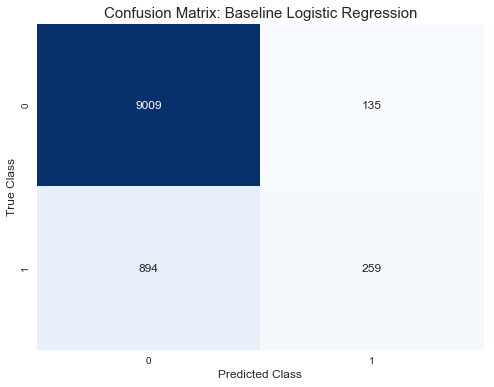

In [34]:
plot_conf_matrix(y_test, logreg_preds, model_name='Baseline Logistic Regression')

As we can see, the baseline logistic regression model achieves an accuracy score of 90%.  However out of 10,297 data points in the test set, it only predicts a 1 (meaning customer subscribed to the deposit) 394 times, when in reality there were 1153 subscribers.  This is a problem with the unbalanced dataset.  The baseline model has a precision score of 66% and recall score of only 22%.  Of those two metrics, we will prefer to prioritize Precision score (TP / (TP+FP)) in order to minimize False Positives.  In our case a False Positive is harmful because we believe a potential customer has subscribed to the term deposit when they have not, therefore the bank may lose out on the customer by not continuing to market to the customer.  False Negatives are not as harmful, may lead to mild annoyance from the customer if they are contacted again about a product they already subscribed to, but the bank has the business and that should become apparent quickly.

Let's see if we get better results if we upsample the minority class to balance our dataset.  We will use SMOTE to upsample  the training data and leave the test data untouched for prediction purposes.

In [35]:
#SMOTE upsampling, and viewing target value counts before and after
print(y_train.value_counts())
X_upsampled_train, y_upsampled_train = SMOTE().fit_sample(X_train, y_train)
print(pd.Series(y_upsampled_train).value_counts())

0    27404
1     3487
Name: deposit, dtype: int64
1    27404
0    27404
dtype: int64


We now have data with equal occurences of our target variable to train on.  Let's run a basic logistic regression again using this training data to see if our model performs any better on the same test data.

### Upsampled Logistic Regression Model (logreg2)

In [36]:
#Instantiate and fit a resampled logistic regression model
logreg2 = LogisticRegression()
logreg2.fit(X_upsampled_train, y_upsampled_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
#make predictions and run metrics on X_test set
logreg2_preds = logreg2.predict(X_test)
logreg2_acc = round(accuracy_score(y_test, logreg2_preds),4)
logreg2_precision = round(precision_score(y_test, logreg2_preds), 4)
logreg2_recall = round(recall_score(y_test, logreg2_preds), 4)
logreg2_f1 = round(f1_score(y_test, logreg2_preds), 4)
print('Upsampled Logistic Regression Model')
print('-' * 60)
print(f'Test Accuracy Score: {logreg2_acc}')
print('-' * 60)
print(f'Test Precision Score: {logreg2_precision}')
print('-' * 60)
print(f'Test Recall Score: {logreg2_recall}')
print('-' * 60)
print(f'Test F1 Score: {logreg2_f1}')
print('-' * 60)
print(classification_report(y_test, logreg2_preds))

Upsampled Logistic Regression Model
------------------------------------------------------------
Test Accuracy Score: 0.8172
------------------------------------------------------------
Test Precision Score: 0.3294
------------------------------------------------------------
Test Recall Score: 0.6106
------------------------------------------------------------
Test F1 Score: 0.428
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9144
           1       0.33      0.61      0.43      1153

    accuracy                           0.82     10297
   macro avg       0.64      0.73      0.66     10297
weighted avg       0.88      0.82      0.84     10297



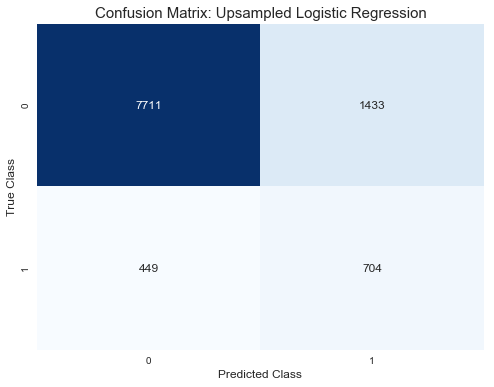

In [38]:
plot_conf_matrix(y_test, logreg2_preds, model_name='Upsampled Logistic Regression')

Using the upsampled data, both our Accuracy (0.82) and Precision (0.33) scores take a hit.  The model got better at predicting the minority class (1 or 'yes' deposit) but it led to a great increase in False Positives which we want to avoid. 

Next we will go back to our original unbalanced data and run a grid search to tune and optimize certain hyperparameters.

In [39]:
#define a parameter grid
logreg_grid = {"C":[.001, .01, .1, 1.0, 10, 100], "penalty":["l1", "l2"], "class_weight": ['balanced', None]}

#define scoring matrix for our gridsearch
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

#define function to run gridsearch given model and parameter grid
def grid_search_wrapper(model, grid, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(model, param_grid = grid, scoring=scorers, refit=refit_score, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    return grid_search
    

In [40]:
grid_search_logreg = grid_search_wrapper(logreg, logreg_grid)

Best params for precision_score
{'C': 0.001, 'class_weight': None, 'penalty': 'l2'}


In [41]:
results = pd.DataFrame(grid_search_logreg.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
3,0.709,0.187,0.900
7,0.703,0.206,0.901
11,0.671,0.227,0.900
15,0.658,0.227,0.899
19,0.657,0.229,0.899


Using our original unbalanced data and a bit of hyperparameter tuning we get a top Precision score of 0.71, an increase of about 6% from our Baseline model.  Let's take a look at our usual scoring metrics and confusion matrix for this model.

### Final Logistic Regression Model (logreg_final)

In [42]:
#final logisic regression model with parameters from the grid search
logreg_final = LogisticRegression(C = .001, class_weight=None, penalty='l2', random_state=random_state)
logreg_final.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
#make predictions and run metrics on X_test set
logreg_final_preds = logreg_final.predict(X_test)
logreg_final_acc = round(accuracy_score(y_test, logreg_final_preds),4)
logreg_final_precision = round(precision_score(y_test, logreg_final_preds), 4)
logreg_final_recall = round(recall_score(y_test, logreg_final_preds), 4)
logreg_final_f1 = round(f1_score(y_test, logreg_final_preds), 4)
print('Final Logistic Regression Model')
print('-' * 60)
print(f'Test Accuracy Score: {logreg_final_acc}')
print('-' * 60)
print(f'Test Precision Score: {logreg_final_precision}')
print('-' * 60)
print(f'Test Recall Score: {logreg_final_recall}')
print('-' * 60)
print(f'Test F1 Score: {logreg_final_f1}')
print('-' * 60)
print(classification_report(y_test, logreg_final_preds))

Final Logistic Regression Model
------------------------------------------------------------
Test Accuracy Score: 0.8997
------------------------------------------------------------
Test Precision Score: 0.684
------------------------------------------------------------
Test Recall Score: 0.1934
------------------------------------------------------------
Test F1 Score: 0.3016
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9144
           1       0.68      0.19      0.30      1153

    accuracy                           0.90     10297
   macro avg       0.80      0.59      0.62     10297
weighted avg       0.88      0.90      0.87     10297



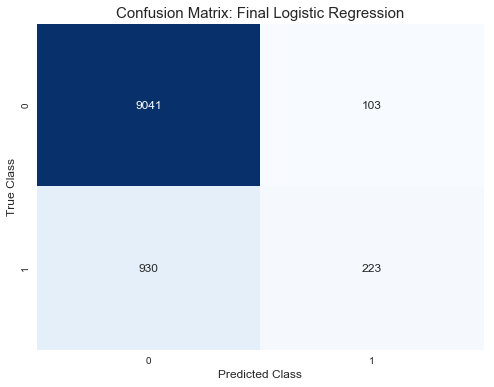

In [44]:
plot_conf_matrix(y_test, logreg_final_preds, model_name='Final Logistic Regression')

With the unbalanced data we are given, without resampling, the model is just always going to predict a lot more of the majority (0 - no deposit in our case) class.  Our final model gives us an Accuracy of 90% and Precision of 68%.  Recall is sacrificed but as explained above we are ok with that in this business case.  Most importantly we have minimized our False Positives.

#### Logreg Final Feature Importance
* Now we take a look at the relative feature importance for our final logistic regression model, sorted by absolute value of the coefficients from the model.

In [45]:
df.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

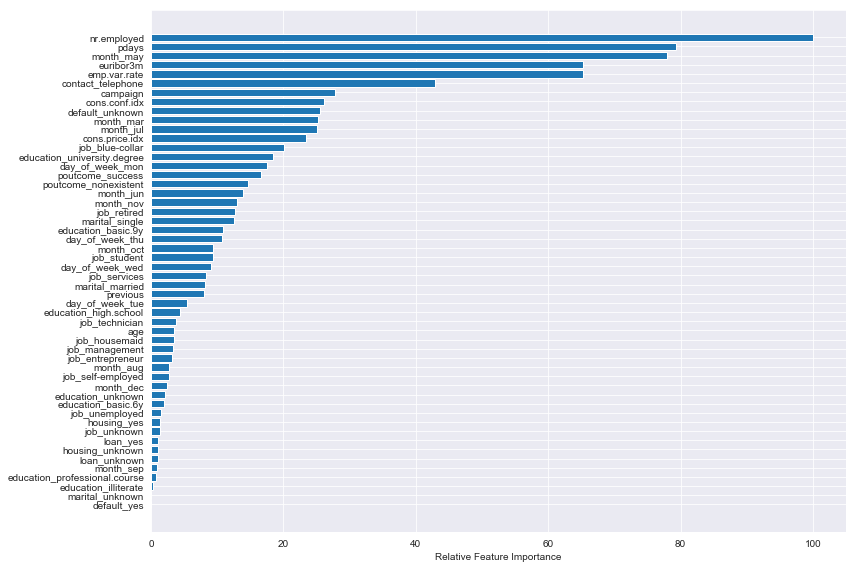

In [46]:
feature_importance = abs(logreg_final.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(feats.columns)[sorted_idx], fontsize=10)
ax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

### Logistic Regression Conclusions
 - The Final Logistic Regression Model optimized for precision score (and using our original unbalanced data) has an Accuracy Score of 90% and Precision Score of 68%, a small improvement over the baseline model.  False positives were minimized, according to our goal but Recall was sacrificed as the model predicted fewer of the minority class.
 - Social and Economic Indicator features dominate the feature importance rankings.  pdays appears near the top as well, that variable shows that the overwhelming majority of customers were not previously contacted for the campaign.  The month of May also has a high importance, likely signaling an important economic event during the month.
  

Next we will look at Decision Trees to classify our data.

### Baseline Decision Tree Model (tree)

In [47]:
#Instantiate and fit a baseline Decision Tree model
tree = DecisionTreeClassifier(random_state=random_state)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [48]:
#make predictions and run metrics on X_test set
tree_preds = tree.predict(X_test)
tree_acc = round(accuracy_score(y_test, tree_preds),4)
tree_precision = round(precision_score(y_test, tree_preds), 4)
tree_recall = round(recall_score(y_test, tree_preds), 4)
tree_f1 = round(f1_score(y_test, tree_preds), 4)
print('Baseline Decision Tree Model')
print('-' * 60)
print(f'Test Accuracy Score: {tree_acc}')
print('-' * 60)
print(f'Test Precision Score: {tree_precision}')
print('-' * 60)
print(f'Test Recall Score: {tree_recall}')
print('-' * 60)
print(f'Test F1 Score: {tree_f1}')
print('-' * 60)
print(classification_report(y_test, tree_preds))

Baseline Decision Tree Model
------------------------------------------------------------
Test Accuracy Score: 0.8404
------------------------------------------------------------
Test Precision Score: 0.3015
------------------------------------------------------------
Test Recall Score: 0.3226
------------------------------------------------------------
Test F1 Score: 0.3117
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      9144
           1       0.30      0.32      0.31      1153

    accuracy                           0.84     10297
   macro avg       0.61      0.61      0.61     10297
weighted avg       0.85      0.84      0.84     10297



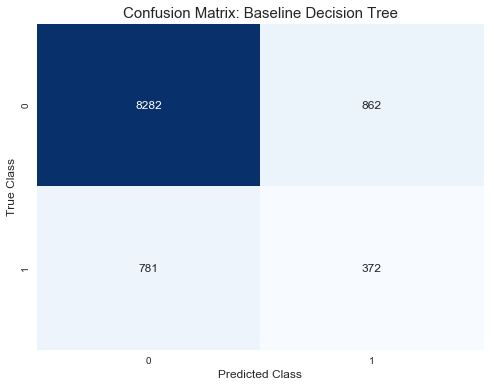

In [49]:
plot_conf_matrix(y_test, tree_preds, model_name='Baseline Decision Tree')

The Baseline Decision Tree model achieves a decent Accuracy score of 84% but suffers in both Precision (30%) and Recall (32%).

Let's take a look at Feature Importance from our baseline Decision Tree.

In [50]:
# Function to print the feature importances
def sort_importance_list(model_classifier, data=feats):
    importances = model_classifier.feature_importances_
    features = data.columns
    features_importance = pd.DataFrame(importances, index=features, columns=['Importance'])
    sorted_feat_imp = features_importance.sort_values('Importance', axis=0, ascending=False)
    return print(sorted_feat_imp)

In [51]:
#Print feature importances from baseline decision tree
sort_importance_list(tree)

                               Importance
age                              0.173231
nr.employed                      0.161569
euribor3m                        0.090208
campaign                         0.079237
housing_yes                      0.039684
pdays                            0.038753
loan_yes                         0.028918
marital_married                  0.025805
cons.conf.idx                    0.022886
education_university.degree      0.021757
job_technician                   0.020712
marital_single                   0.017669
education_high.school            0.017522
day_of_week_wed                  0.017418
day_of_week_mon                  0.016286
day_of_week_tue                  0.015996
default_unknown                  0.015759
day_of_week_thu                  0.015664
previous                         0.014833
job_blue-collar                  0.014063
education_basic.9y               0.013868
job_management                   0.012135
job_services                     0

Next we will run the Decision Tree on our SMOTE balanced data.

### Upsampled Decision Tree Model (tree2)

In [52]:
#Instantiate and fit a resampled decision tree model
tree2 = DecisionTreeClassifier()
tree2.fit(X_upsampled_train, y_upsampled_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [53]:
#make predictions and run metrics on X_test set
tree2_preds = tree2.predict(X_test)
tree2_acc = round(accuracy_score(y_test, tree2_preds),4)
tree2_precision = round(precision_score(y_test, tree2_preds), 4)
tree2_recall = round(recall_score(y_test, tree2_preds), 4)
tree2_f1 = round(f1_score(y_test, tree2_preds), 4)
print('Upsampled Decision Tree Model')
print('-' * 60)
print(f'Test Accuracy Score: {tree2_acc}')
print('-' * 60)
print(f'Test Precision Score: {tree2_precision}')
print('-' * 60)
print(f'Test Recall Score: {tree2_recall}')
print('-' * 60)
print(f'Test F1 Score: {tree2_f1}')
print('-' * 60)
print(classification_report(y_test, tree2_preds))

Upsampled Decision Tree Model
------------------------------------------------------------
Test Accuracy Score: 0.8418
------------------------------------------------------------
Test Precision Score: 0.3178
------------------------------------------------------------
Test Recall Score: 0.3599
------------------------------------------------------------
Test F1 Score: 0.3375
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9144
           1       0.32      0.36      0.34      1153

    accuracy                           0.84     10297
   macro avg       0.62      0.63      0.62     10297
weighted avg       0.85      0.84      0.85     10297



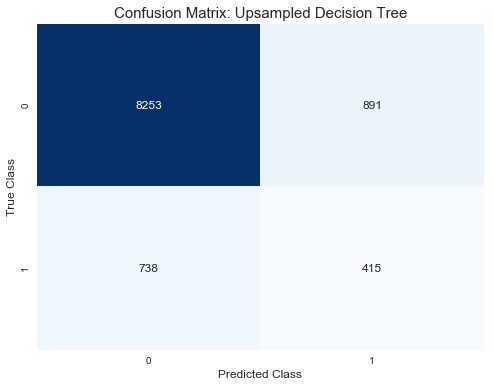

In [54]:
plot_conf_matrix(y_test, tree2_preds, model_name='Upsampled Decision Tree')

Using the upsampled data does not help our case.  Accuracy, Recall and Precision are all pretty much the same, and there is an uptick in False Positives which we are trying to avoid.  



In [55]:
#Print feature importances from upsampled decision tree
sort_importance_list(tree2)

                               Importance
nr.employed                      0.203496
campaign                         0.177985
euribor3m                        0.086393
age                              0.074038
cons.conf.idx                    0.055938
default_unknown                  0.040402
contact_telephone                0.037544
housing_yes                      0.036012
loan_yes                         0.018855
day_of_week_wed                  0.018085
day_of_week_thu                  0.016585
day_of_week_tue                  0.016478
day_of_week_mon                  0.015153
marital_married                  0.014849
education_university.degree      0.014097
month_oct                        0.011982
job_technician                   0.011806
job_services                     0.010005
marital_single                   0.009336
education_high.school            0.009328
job_blue-collar                  0.009115
cons.price.idx                   0.008922
education_basic.9y               0

Top 4 most important features are the same as our baseline decision tree - nr.employed, campaign, euribor3m, and age.

We will stick with our original pre-SMOTE data, and see if we can improve our metrics by tuning some hyperparameters.

### Final Decision Tree Using Gridsearch to tune hyperparameters (tree_final)

In [56]:
#define parameter grid
tree_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': range(2,10),
             'max_features': range(5,25,5),
             'max_leaf_nodes': range(5,40,5),
             'min_samples_split': range(2,20,2)}
             
grid_search_tree = grid_search_wrapper(tree, tree_grid)

Best params for precision_score
{'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}


In [57]:
results = pd.DataFrame(grid_search_tree.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
1838,0.765,0.107,0.895
1585,0.765,0.107,0.895
1082,0.765,0.107,0.895
1080,0.765,0.107,0.895
1337,0.765,0.107,0.895


Taking a quick look at the results from our Gridsearch optimizing for Precision Score, we see some much improved Precision scores of 0.765 and Accuracy of 0.895.  Recall takes a big hit down to around 11%

Let's look at the model and metrics using our tuned hyperparameters.

In [58]:
tree_final = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=10, max_leaf_nodes=10, 
                                    min_samples_split=2, random_state=random_state)
tree_final.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=10, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [59]:
tree_final_preds = tree_final.predict(X_test)
tree_final_acc = round(accuracy_score(y_test, tree_final_preds),4)
tree_final_precision = round(precision_score(y_test, tree_final_preds), 4)
tree_final_recall = round(recall_score(y_test, tree_final_preds), 4)
tree_final_f1 = round(f1_score(y_test, tree_final_preds), 4)
print('Final Decision Tree Model')
print('-' * 60)
print(f'Test Accuracy Score: {tree_final_acc}')
print('-' * 60)
print(f'Test Precision Score: {tree_final_precision}')
print('-' * 60)
print(f'Test Recall Score: {tree_final_recall}')
print('-' * 60)
print(f'Test F1 Score: {tree_final_f1}')
print('-' * 60)
print(classification_report(y_test, tree_final_preds))

Final Decision Tree Model
------------------------------------------------------------
Test Accuracy Score: 0.8969
------------------------------------------------------------
Test Precision Score: 0.8013
------------------------------------------------------------
Test Recall Score: 0.1049
------------------------------------------------------------
Test F1 Score: 0.1856
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      9144
           1       0.80      0.10      0.19      1153

    accuracy                           0.90     10297
   macro avg       0.85      0.55      0.57     10297
weighted avg       0.89      0.90      0.86     10297



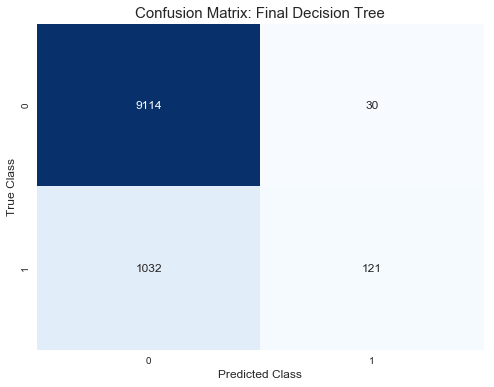

In [60]:
plot_conf_matrix(y_test, tree_final_preds, model_name='Final Decision Tree')

In [61]:
#Print feature importances from final decision tree
sort_importance_list(tree_final)

                               Importance
emp.var.rate                     0.496376
euribor3m                        0.339672
poutcome_success                 0.037236
cons.conf.idx                    0.032331
contact_telephone                0.028398
month_mar                        0.026208
pdays                            0.025286
age                              0.014493
month_sep                        0.000000
month_aug                        0.000000
month_dec                        0.000000
month_jul                        0.000000
month_jun                        0.000000
month_may                        0.000000
month_nov                        0.000000
month_oct                        0.000000
job_blue-collar                  0.000000
day_of_week_mon                  0.000000
day_of_week_thu                  0.000000
job_entrepreneur                 0.000000
day_of_week_wed                  0.000000
poutcome_nonexistent             0.000000
campaign                         0

### Decision Tree Conclusions
 - The Final Decision Tree Model optimized for precision score has very similar Accuracy score as the Final Logistic Regression Model ~90%
 - Precision Score of 80% is the highest yet with only 30 False Positives, but significant reduction in Recall due to predicting very few of the minority class. 
 - emp.var.rate and euribor3m (similar to Fed Funds rate in the US) are by far our most important feature in the final model, and among the top few most important features in our other models.  Economic indicators overall do most of the lifting in predicting the target variable.
 - There are other hyperparameters we could tune, and could try optimizing the model for other metrics for comparison sake, but in interest of time (and computational expense) we will conclude the Decision Tree modeling here.
  

### Baseline Random Forest Model (rf)

The final model we want to look at is the Random Forest Ensemble Model.  

In [62]:
#Instantiate and fit random forest classifier
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
#make predictions and run metrics on X_test set
rf_preds = rf.predict(X_test)
rf_acc = round(accuracy_score(y_test, rf_preds),4)
rf_precision = round(precision_score(y_test, rf_preds), 4)
rf_recall = round(recall_score(y_test, rf_preds), 4)
rf_f1 = round(f1_score(y_test, rf_preds), 4)
print('Baseline Random Forest Model')
print('-' * 60)
print(f'Test Accuracy Score: {rf_acc}')
print('-' * 60)
print(f'Test Precision Score: {rf_precision}')
print('-' * 60)
print(f'Test Recall Score: {rf_recall}')
print('-' * 60)
print(f'Test F1 Score: {rf_f1}')
print('-' * 60)
print(classification_report(y_test, rf_preds))

Baseline Random Forest Model
------------------------------------------------------------
Test Accuracy Score: 0.8921
------------------------------------------------------------
Test Precision Score: 0.5337
------------------------------------------------------------
Test Recall Score: 0.2888
------------------------------------------------------------
Test F1 Score: 0.3748
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9144
           1       0.53      0.29      0.37      1153

    accuracy                           0.89     10297
   macro avg       0.72      0.63      0.66     10297
weighted avg       0.87      0.89      0.88     10297



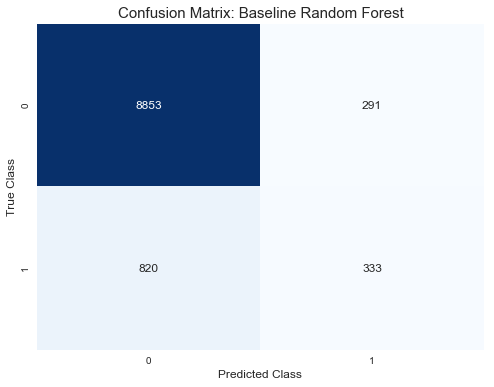

In [64]:
plot_conf_matrix(y_test, rf_preds, model_name='Baseline Random Forest')

In [65]:
#Print feature importances random forest
sort_importance_list(rf)

                                 Importance
age                            1.699387e-01
euribor3m                      1.282097e-01
campaign                       8.518422e-02
nr.employed                    5.184117e-02
pdays                          3.898944e-02
housing_yes                    3.809545e-02
poutcome_success               3.090119e-02
cons.conf.idx                  2.632051e-02
loan_yes                       2.514117e-02
cons.price.idx                 2.345119e-02
marital_married                2.108051e-02
marital_single                 1.763916e-02
education_university.degree    1.756741e-02
education_high.school          1.727446e-02
previous                       1.725881e-02
job_technician                 1.716498e-02
day_of_week_mon                1.646987e-02
day_of_week_wed                1.641480e-02
day_of_week_tue                1.629035e-02
emp.var.rate                   1.614080e-02
day_of_week_thu                1.584765e-02
contact_telephone              1

Initial reactions are that the out of the box Random Forest classifier performs fairly well with an 89% Accuracy and 53% Precision.  This outperforms the Baseline Decision Tree on both metrics.  The Precision score is lower than that of the Baseline Logistic Regression model, but the tradeoff is that here we predict a larger number of the minority target case (624 vs 393), closer to the actual number of clients that subscribe to the deposit.  In terms of feature importances, the same features appear near the top as we saw with our Decision Tree models: nr.employed, campaign, euribor3m, and age.

Let's run a random forest model with the SMOTE upsampled data as well.

### Upsampled Random Forest Model (rf2)

In [66]:
#Instantiate and fit a resampled random forest model
rf2 = RandomForestClassifier(random_state=random_state)
rf2.fit(X_upsampled_train, y_upsampled_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [67]:
#make predictions and run metrics on X_test set
rf2_preds = tree2.predict(X_test)
rf2_acc = round(accuracy_score(y_test, rf2_preds),4)
rf2_precision = round(precision_score(y_test, rf2_preds), 4)
rf2_recall = round(recall_score(y_test, rf2_preds), 4)
rf2_f1 = round(f1_score(y_test, rf2_preds), 4)
print('Upsampled Random Forest Model')
print('-' * 60)
print(f'Test Accuracy Score: {rf2_acc}')
print('-' * 60)
print(f'Test Precision Score: {rf2_precision}')
print('-' * 60)
print(f'Test Recall Score: {rf2_recall}')
print('-' * 60)
print(f'Test F1 Score: {rf2_f1}')
print('-' * 60)
print(classification_report(y_test, rf2_preds))

Upsampled Random Forest Model
------------------------------------------------------------
Test Accuracy Score: 0.8418
------------------------------------------------------------
Test Precision Score: 0.3178
------------------------------------------------------------
Test Recall Score: 0.3599
------------------------------------------------------------
Test F1 Score: 0.3375
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9144
           1       0.32      0.36      0.34      1153

    accuracy                           0.84     10297
   macro avg       0.62      0.63      0.62     10297
weighted avg       0.85      0.84      0.85     10297



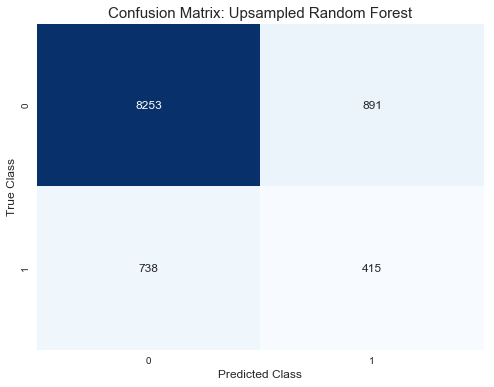

In [68]:
plot_conf_matrix(y_test, rf2_preds, model_name='Upsampled Random Forest')

In [69]:
#Print feature importances for upsampled random forest
sort_importance_list(rf2)

                                 Importance
euribor3m                      1.255488e-01
campaign                       9.202897e-02
age                            7.925270e-02
nr.employed                    6.295304e-02
housing_yes                    4.646551e-02
default_unknown                3.763727e-02
emp.var.rate                   3.740299e-02
contact_telephone              3.689127e-02
cons.conf.idx                  3.019627e-02
loan_yes                       2.998048e-02
cons.price.idx                 2.639249e-02
day_of_week_mon                2.380179e-02
day_of_week_wed                2.358408e-02
day_of_week_thu                2.272963e-02
day_of_week_tue                2.174774e-02
poutcome_success               2.077008e-02
marital_married                2.027319e-02
pdays                          2.007902e-02
education_university.degree    1.812312e-02
job_technician                 1.678458e-02
month_may                      1.652840e-02
job_blue-collar                1

Like previous models with the upsampled data, while the model predicts the minority class (1 - yes deposit) more often, our scoring metrics of Accuracy and Precision suffer.  

### Random Forest Conclusions
 - The baseline model performs well - 89% accuracy and 53% precision, probably our 2nd best model after our final logistic regression model.
 - Shows same most important features
 - The Random Forest model could be improved through hyperparameter tuning, especially to increase our our Precision score and limit False Positives.   However, because each model is a compilation of many decision trees it is computationally expensive and we are going to leave it at the baseline model for now.

### Comparing Model Performance

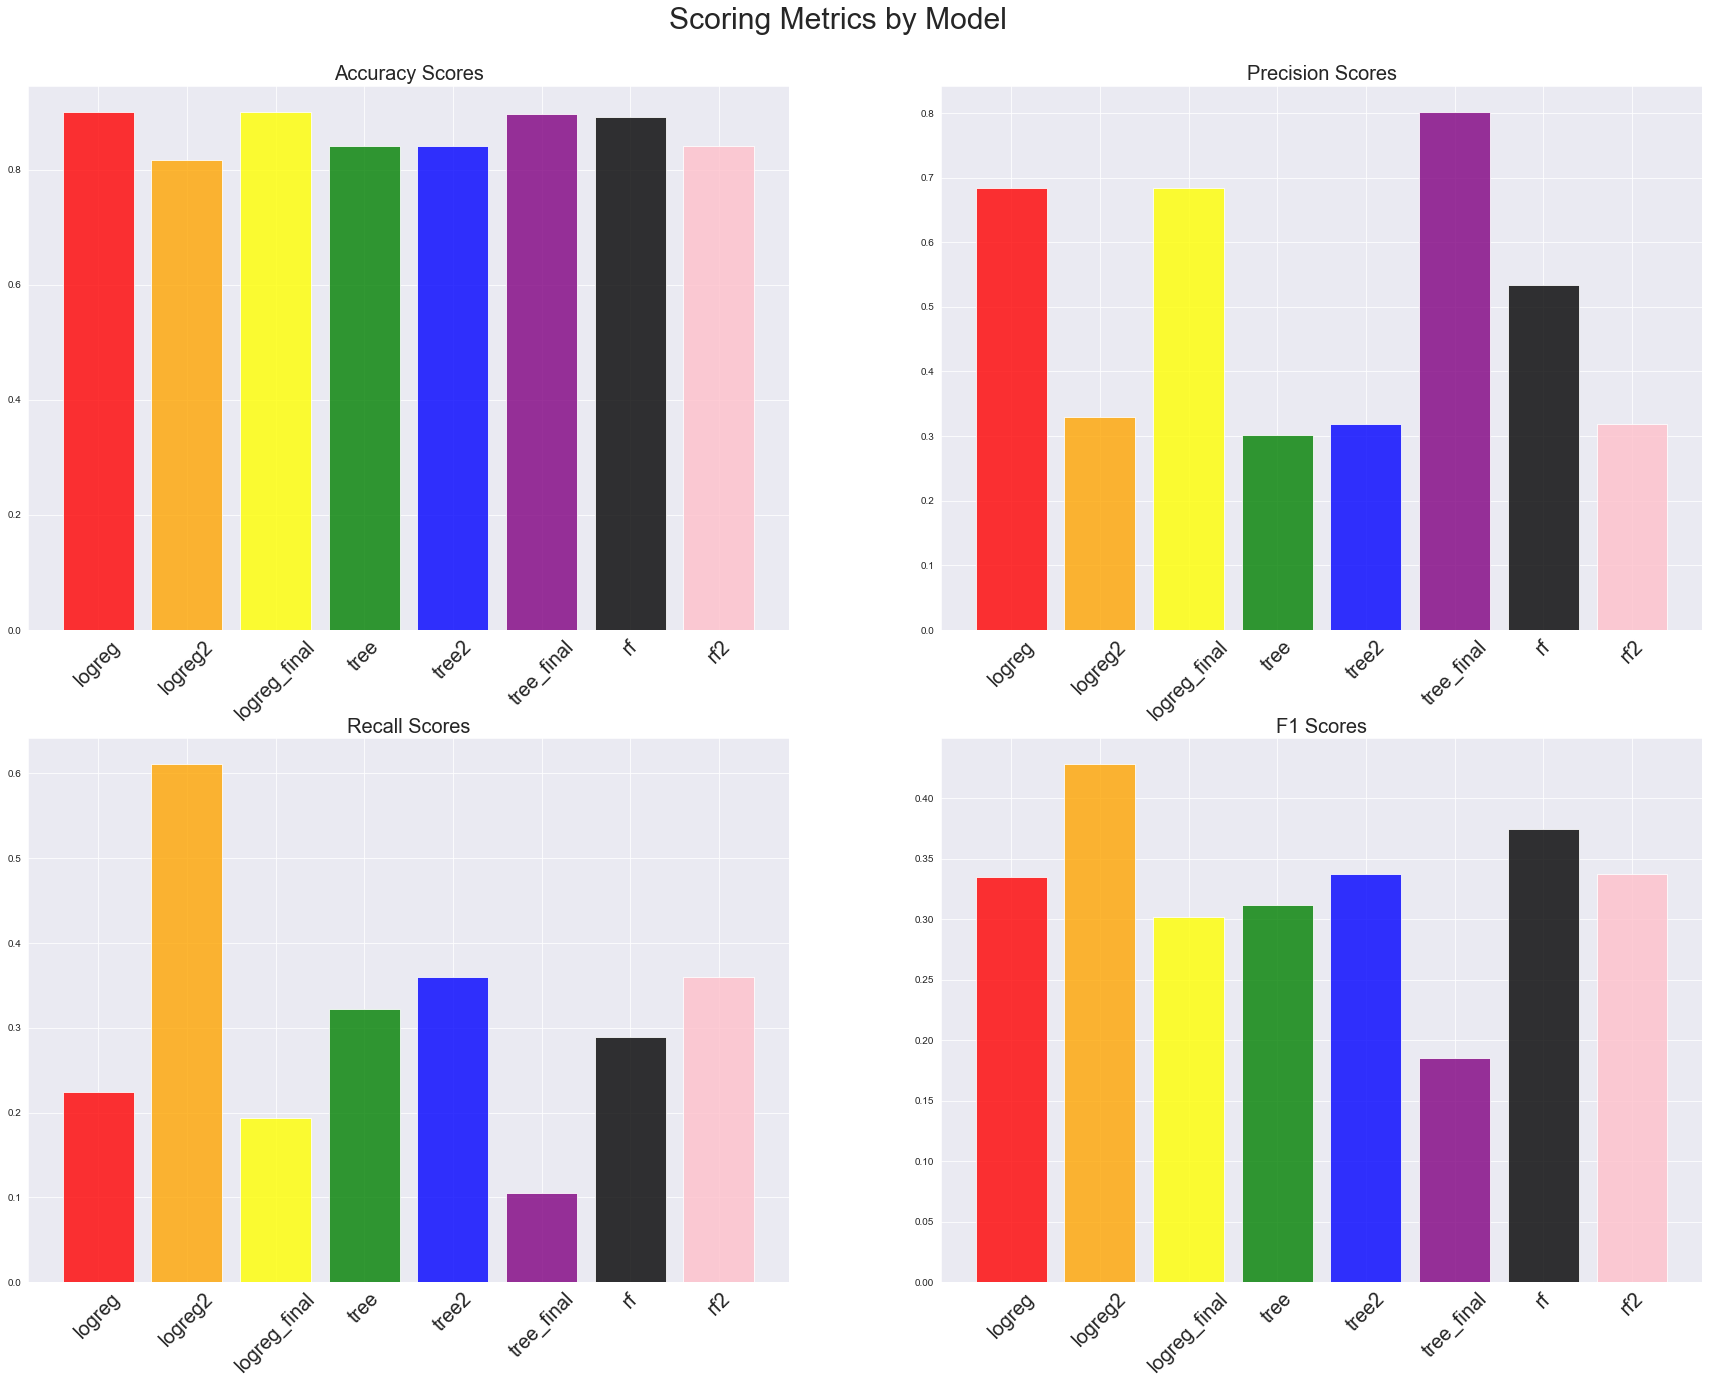

In [75]:
#Plot bar charts of scoring metrics of each of our models
models = ['logreg', 'logreg2', 'logreg_final', 'tree', 'tree2', 'tree_final', 'rf', 'rf2']

acc_scores = [logreg_acc, logreg2_acc, logreg_final_acc, tree_acc, tree2_acc, tree_final_acc, rf_acc, rf2_acc]
precision_scores = [logreg_final_precision, logreg2_precision, logreg_final_precision, tree_precision,
                    tree2_precision, tree_final_precision, rf_precision, rf2_precision]
recall_scores = [logreg_recall, logreg2_recall, logreg_final_recall, tree_recall, tree2_recall, 
                 tree_final_recall, rf_recall, rf2_recall]
f1_scores = [logreg_f1, logreg2_f1, logreg_final_f1, tree_f1, tree2_f1, tree_final_f1, rf_f1, rf2_f1]

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'pink']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(30,22))
ax1.bar(models, acc_scores, alpha = 0.8, color=colors)
ax2.bar(models, precision_scores, alpha = 0.8, color=colors)
ax3.bar(models, recall_scores, alpha = 0.8, color=colors)
ax4.bar(models, f1_scores, alpha = 0.8, color=colors)

ax1.set_title('Accuracy Scores', fontsize=20)
ax2.set_title('Precision Scores', fontsize=20)
ax3.set_title('Recall Scores', fontsize=20)
ax4.set_title('F1 Scores', fontsize=20)

ax1.xaxis.set_tick_params(labelsize=20, rotation=45)
ax2.xaxis.set_tick_params(labelsize=20, rotation=45)
ax3.xaxis.set_tick_params(labelsize=20, rotation=45)
ax4.xaxis.set_tick_params(labelsize=20, rotation=45)

plt.suptitle('Scoring Metrics by Model', fontsize=30, y = 0.93)
plt.show()


In [71]:
#Build and display a dataframe of the 4 scoring metrics for each of our models
model_performance = pd.DataFrame(index=models, columns=['Accuracy', 'Precision', 'Recall', 'F1'])
model_performance.Accuracy = acc_scores
model_performance.Precision = precision_scores
model_performance.Recall = recall_scores
model_performance.F1 = f1_scores
model_performance

,Accuracy,Precision,Recall,F1
logreg,0.9001,0.6840,0.2246,0.3348
logreg2,0.8172,0.3294,0.6106,0.4280
logreg_final,0.8997,0.6840,0.1934,0.3016
tree,0.8404,0.3015,0.3226,0.3117
tree2,0.8418,0.3178,0.3599,0.3375
tree_final,0.8969,0.8013,0.1049,0.1856
rf,0.8921,0.5337,0.2888,0.3748
rf2,0.8418,0.3178,0.3599,0.3375


In [72]:
#View models sorted by Precision Score
model_performance.sort_values('Precision', ascending=False)

,Accuracy,Precision,Recall,F1
tree_final,0.8969,0.8013,0.1049,0.1856
logreg,0.9001,0.6840,0.2246,0.3348
logreg_final,0.8997,0.6840,0.1934,0.3016
rf,0.8921,0.5337,0.2888,0.3748
logreg2,0.8172,0.3294,0.6106,0.4280
tree2,0.8418,0.3178,0.3599,0.3375
rf2,0.8418,0.3178,0.3599,0.3375
tree,0.8404,0.3015,0.3226,0.3117


In [73]:
#View models sorted by Accuracy Score
model_performance.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1
logreg,0.9001,0.6840,0.2246,0.3348
logreg_final,0.8997,0.6840,0.1934,0.3016
tree_final,0.8969,0.8013,0.1049,0.1856
rf,0.8921,0.5337,0.2888,0.3748
tree2,0.8418,0.3178,0.3599,0.3375
rf2,0.8418,0.3178,0.3599,0.3375
tree,0.8404,0.3015,0.3226,0.3117
logreg2,0.8172,0.3294,0.6106,0.4280


#### Another look at Distributions of our Most Important Features
 * euribor3m, age, nr.employed and emp.var.rate commonly appear among the most important features in our tree models.
 * We will show violin plots of these features, by target class.

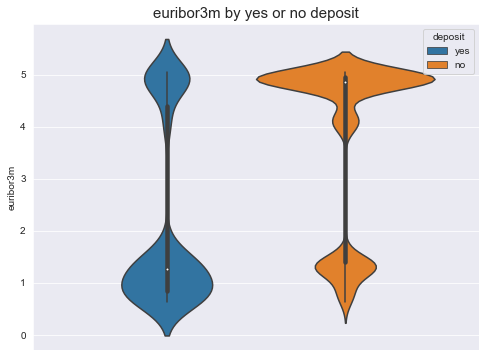

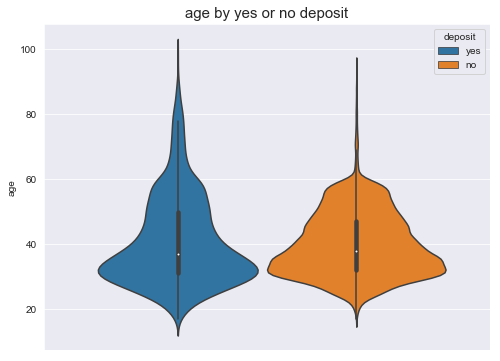

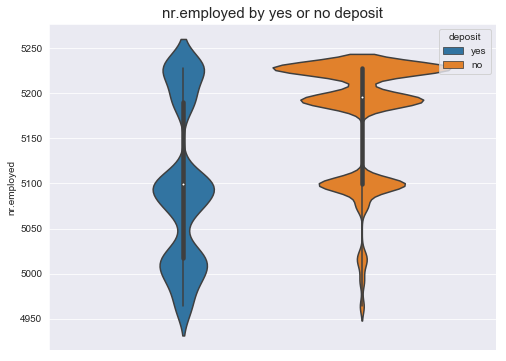

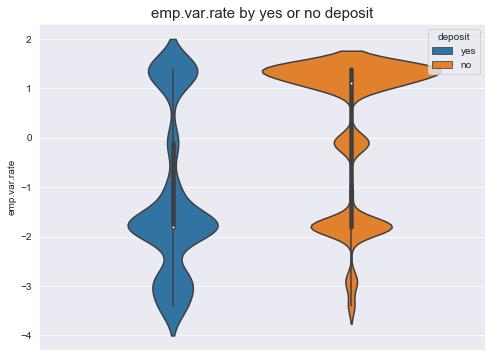

In [74]:
#Plot violin plots for 4 features, grouped by target deposit class
df['all'] = ''
for col in ['euribor3m', 'age', 'nr.employed', 'emp.var.rate']:
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(111)
    ax = sns.violinplot(x='all', y=col, data=df, hue='deposit', hue_order=['yes', 'no'], orient="v")
    ax.set_title(f'{col} by yes or no deposit', fontsize = 15)
    plt.xlabel("")
    print('\n')
    plt.show()

#### Important Feature Insights:
 * The lower the euribor3m rate, the more likely customers are to subscribe.
 * The age range of subscribers looks bigger, but peaks slightly younger.
 * People are more likely to subscribe when the nr.employed and emp.var.rate indicators are lower. 

## Conclusions

* We ran a total of 8 machine learning models (3 Logistic Regression, 3 Decision Trees and 2 Random Forests) using original and upsampled data from the Bank Marketing Dataset.  
* Several models had an Accuracy Score in the 89-90% range.  Our Final Decision Tree model scored highest in Precision at 80%.
* For Logistic Regression and Decision Tree models, we performed hyperparameter tuning to optimize for Precision.  The goal was to minimize False Positives to avoid missing out on misclassified customers who had not subscribed to the term deposit.
* The baseline Random Forest Model showed promise but due to time constraints we did not do any hyperparameter tuning to further optimize it.
* Feature Importance analysis showed that social and economic variables were for the main part the most important predictors of whether the customers make the deposit.  Makes the timing of the marketing campaign the most important thing.


### Future Work
* Run other classification algorithms and ensemble methods to compare the results to our existing model as well as continue to tune the models we did use (especially Random Forest)
* While the scores would likely suffer, would be interesting to model and attempt to make predictions with just the client data (without the social/economic factors) to see what insights can be gleaned and improve the targeted client marketing for future investment products.
